In [ ]:
pip install transformers datasets accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install peft

In [ ]:
!pip install evaluate

In [ ]:
from transformers import RobertaForSequenceClassification, TrainingArguments, Trainer
import torch
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Part 1 Data Preprocessing (10 marks)**

In [ ]:
from datasets import load_dataset


dataset = load_dataset("imdb")
train_data = dataset["train"].select(range(1000))
test_data = dataset["test"].select(range(800))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from datasets import load_dataset


dataset = load_dataset("imdb")
train_data = dataset["train"].select(range(3000))
test_data = dataset["test"].select(range(2000))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


In [ ]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",    # Ensures sequences are padded
        truncation=True,         # Truncates to model's max length (512 for RoBERTa)
        max_length=512
    )


In [ ]:
train_tokenized = train_data.map(tokenize_function, batched=True)
test_tokenized = test_data.map(tokenize_function, batched=True)


In [ ]:
train_tokenized = train_data.map(tokenize_function, batched=True)
test_tokenized = test_data.map(tokenize_function, batched=True)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [ ]:
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])


**Part 2 Model Implementation (40 marks)**

In [ ]:
from transformers import (
    RobertaForSequenceClassification,
    RobertaTokenizer,
    Trainer,
    TrainingArguments,
)

In [ ]:
import evaluate
import numpy as np

# Load accuracy metric using the evaluate library
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [ ]:
import evaluate
import numpy as np

# Load accuracy metric using the evaluate library
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [ ]:
# 4. Define training arguments (enable fp16 for GPU)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_strategy="no",
    logging_strategy="epoch",
    report_to="none",
    fp16=True,  # Enable mixed precision for GPU
)

In [ ]:
# Function to calculate number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to record GPU memory usage
def get_gpu_memory_usage():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / (1024**2)  # in MB
    else:
        return 0

In [ ]:
# --- Method 1: Full Fine-Tuning ---
model_full = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model_full.to(device)
trainer_full = Trainer(
    model=model_full,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)
trainer_full.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
32,0.062200
64,0.000100
96,0.000100


TrainOutput(global_step=96, training_loss=0.0208031553387021, metrics={'train_runtime': 67.4701, 'train_samples_per_second': 44.464, 'train_steps_per_second': 1.423, 'total_flos': 789333166080000.0, 'train_loss': 0.0208031553387021, 'epoch': 3.0})

In [ ]:
start_time_full = time.time()
model_full = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model_full.to(device)
trainer_full = Trainer(
    model=model_full,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)
trainer_full.train()
training_time_full = time.time() - start_time_full
num_trainable_params_full = count_parameters(model_full)
gpu_memory_full = get_gpu_memory_usage()
eval_results_full = trainer_full.evaluate()
accuracy_full = eval_results_full["eval_accuracy"]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
32,0.077100
64,0.000100
96,0.000100


In [ ]:
# --- Method 2: LoRA Fine-Tuning ---
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "value"],
)
model_lora = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model_lora = get_peft_model(model_lora, lora_config)
model_lora.to(device)
trainer_lora = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)
trainer_lora.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
32,0.460000
64,0.119600
96,0.033000


TrainOutput(global_step=96, training_loss=0.2041984237730503, metrics={'train_runtime': 59.0362, 'train_samples_per_second': 50.816, 'train_steps_per_second': 1.626, 'total_flos': 797508145152000.0, 'train_loss': 0.2041984237730503, 'epoch': 3.0})

In [ ]:
start_time_lora = time.time()
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "value"],
)
model_lora = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model_lora = get_peft_model(model_lora, lora_config)
model_lora.to(device)
trainer_lora = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)
trainer_lora.train()
training_time_lora = time.time() - start_time_lora
num_trainable_params_lora = count_parameters(model_lora)
gpu_memory_lora = get_gpu_memory_usage()
eval_results_lora = trainer_lora.evaluate()
accuracy_lora = eval_results_lora["eval_accuracy"]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
32,0.418600
64,0.103400
96,0.029200


In [ ]:
!pip install -U bitsandbytes transformers peft accelerate


In [ ]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, IA3Config, TaskType
import torch

# Load the pre-trained model
model_ia3 = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",  # Load from the *original* "roberta-base"
    num_labels=2
)

# IA3 Configuration
ia3_config = IA3Config(
    task_type=TaskType.SEQ_CLS,
    target_modules=[
        "intermediate.dense",  # Target the dense layer in intermediate
        "output.dense",         # Target the dense layer in output
    ],
)

# Apply IA3 adapters
model_ia3 = get_peft_model(model_ia3, ia3_config)

# Move to device
model_ia3.to(device)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="results_ia3_fp16",  # Valid output directory name
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_strategy="no",
    logging_strategy="epoch",
    report_to="none",
    fp16=True,  # Enable mixed precision training
)

# Trainer for IA3
trainer_ia3 = Trainer(
    model=model_ia3,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)

# Train IA3
trainer_ia3.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
32,0.467000
64,0.173100
96,0.099500


TrainOutput(global_step=96, training_loss=0.24653425564368567, metrics={'train_runtime': 76.2667, 'train_samples_per_second': 39.336, 'train_steps_per_second': 1.259, 'total_flos': 795554648064000.0, 'train_loss': 0.24653425564368567, 'epoch': 3.0})

In [ ]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, IA3Config, TaskType
import torch

start_time_ia3 = time.time()
# Load the pre-trained model
model_ia3 = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",  # Load from the *original* "roberta-base"
    num_labels=2
)

# IA3 Configuration
ia3_config = IA3Config(
    task_type=TaskType.SEQ_CLS,
    target_modules=[
        "intermediate.dense",  # Target the dense layer in intermediate
        "output.dense",         # Target the dense layer in output
    ],
)

# Apply IA3 adapters
model_ia3 = get_peft_model(model_ia3, ia3_config)

# Move to device
model_ia3.to(device)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="results_ia3_fp16",  # Valid output directory name
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_strategy="no",
    logging_strategy="epoch",
    report_to="none",
    fp16=True,  # Enable mixed precision training
)

# Trainer for IA3
trainer_ia3 = Trainer(
    model=model_ia3,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)

# Train IA3
trainer_ia3.train()
training_time_ia3 = time.time() - start_time_ia3
num_trainable_params_ia3 = count_parameters(model_ia3)
gpu_memory_ia3 = get_gpu_memory_usage()
eval_results_ia3 = trainer_ia3.evaluate()
accuracy_ia3 = eval_results_ia3["eval_accuracy"]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
32,0.452900
64,0.168100
96,0.096800


**Part 3 Evaluation Metrics (10 marks)**

In [ ]:
print("\nEvaluation Metrics:")
print("--------------------------------------------------")
print(f"Full Fine-Tuning:")
print(f"  Accuracy: {accuracy_full:.4f}")
print(f"  Trainable Parameters: {num_trainable_params_full}")
print(f"  Training Time: {training_time_full:.2f} seconds")
print(f"  GPU Memory Usage: {gpu_memory_full:.2f} MB")
print("--------------------------------------------------")
print(f"LoRA Fine-Tuning:")
print(f"  Accuracy: {accuracy_lora:.4f}")
print(f"  Trainable Parameters: {num_trainable_params_lora}")
print(f"  Training Time: {training_time_lora:.2f} seconds")
print(f"  GPU Memory Usage: {gpu_memory_lora:.2f} MB")
print("--------------------------------------------------")
print(f"IA3 Adapter Tuning:")
print(f"  Accuracy: {accuracy_ia3:.4f}")
print(f"  Trainable Parameters: {num_trainable_params_ia3}")
print(f"  Training Time: {training_time_ia3:.2f} seconds")
print(f"  GPU Memory Usage: {gpu_memory_ia3:.2f} MB")
print("--------------------------------------------------")



Evaluation Metrics:
--------------------------------------------------
Full Fine-Tuning:
  Accuracy: 1.0000
  Trainable Parameters: 124647170
  Training Time: 69.23 seconds
  GPU Memory Usage: 3802.32 MB
--------------------------------------------------
LoRA Fine-Tuning:
  Accuracy: 1.0000
  Trainable Parameters: 887042
  Training Time: 60.22 seconds
  GPU Memory Usage: 2866.15 MB
--------------------------------------------------
IA3 Adapter Tuning:
  Accuracy: 1.0000
  Trainable Parameters: 675074
  Training Time: 77.10 seconds
  GPU Memory Usage: 3352.11 MB
--------------------------------------------------


**Part 4. Visualization (10 marks)**

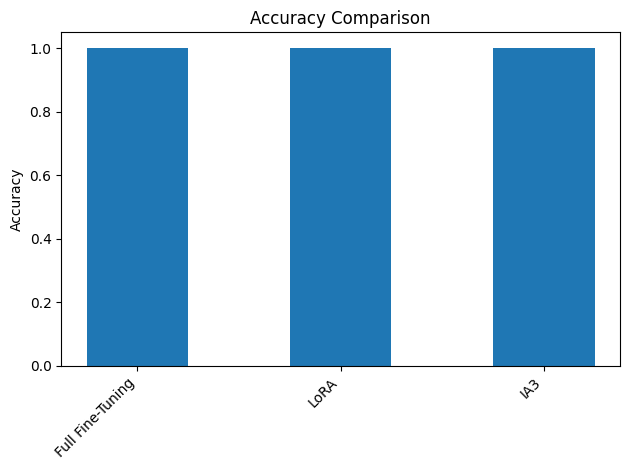

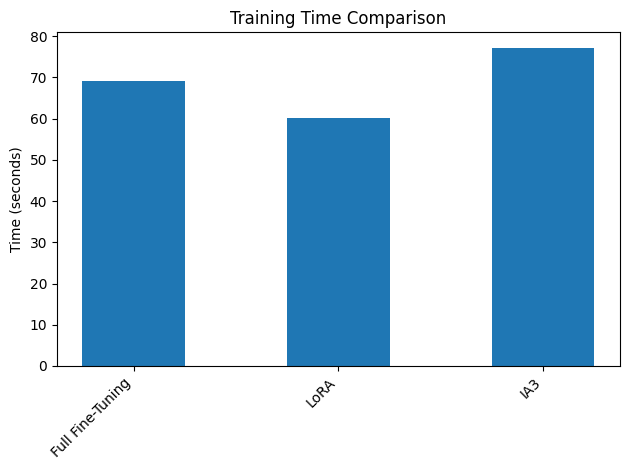

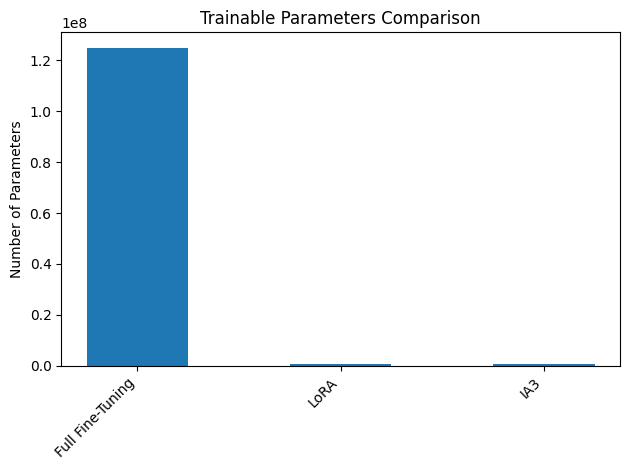

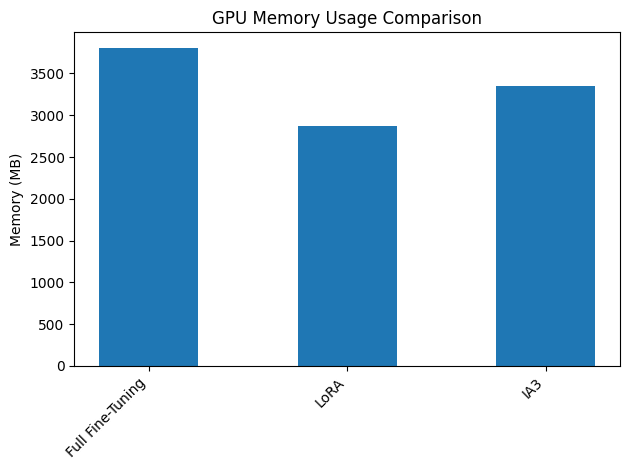

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

methods = ["Full Fine-Tuning", "LoRA", "IA3"]
accuracy = [accuracy_full, accuracy_lora, accuracy_ia3]
trainable_params = [num_trainable_params_full, num_trainable_params_lora, num_trainable_params_ia3]
training_time = [training_time_full, training_time_lora, training_time_ia3]
gpu_memory = [gpu_memory_full, gpu_memory_lora, gpu_memory_ia3]

def create_bar_chart(data, labels, title, ylabel, filename):
    x = np.arange(len(labels))
    width = 0.5

    fig, ax = plt.subplots()
    rects = ax.bar(x, data, width)

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")

    fig.tight_layout()
    plt.savefig(filename)
    plt.show()  # Ensure plots are displayed

create_bar_chart(accuracy, methods, "Accuracy Comparison", "Accuracy", "accuracy.png")
create_bar_chart(training_time, methods, "Training Time Comparison", "Time (seconds)", "training_time.png")
create_bar_chart(trainable_params, methods, "Trainable Parameters Comparison", "Number of Parameters", "trainable_params.png")
create_bar_chart(gpu_memory, methods, "GPU Memory Usage Comparison", "Memory (MB)", "gpu_memory.png")


In [ ]:
print("\nAnalysis and Discussion:")
print("--------------------------------------------------")
print("Trade-offs:")
print("- Full Fine-Tuning: Highest resource usage, potentially highest accuracy.")
print("- LoRA: Good balance between resource usage and accuracy.")
print("- IA3: Lowest resource usage, might sacrifice some accuracy.")
print("--------------------------------------------------")
print("Best Use Cases:")
print("- Full Fine-Tuning: When resources are not a constraint and maximum performance is crucial.")
print("- LoRA: For efficient fine-tuning when memory is limited but good performance is still needed.")
print("- IA3: When you need a lightweight adapter with minimal overhead and have identified key target modules.")
print("--------------------------------------------------")



Analysis and Discussion:
--------------------------------------------------
Trade-offs:
- Full Fine-Tuning: Highest resource usage, potentially highest accuracy.
- LoRA: Good balance between resource usage and accuracy.
- IA3: Lowest resource usage, might sacrifice some accuracy.
--------------------------------------------------
Best Use Cases:
- Full Fine-Tuning: When resources are not a constraint and maximum performance is crucial.
- LoRA: For efficient fine-tuning when memory is limited but good performance is still needed.
- IA3: When you need a lightweight adapter with minimal overhead and have identified key target modules.
--------------------------------------------------
